### KDD CUP 2012
Search advertising has been one of the major revenue sources of the Internet industry for years. A key technology behind search advertising is to predict the click-through rate (pCTR) of ads, as the economic model behind search advertising requires pCTR values to rank ads and to price clicks. In this task, given the training instances derived from session logs of the Tencent proprietary search engine, soso.com, participants are expected to accurately predict the pCTR of ads in the testing instances.
https://www.kaggle.com/c/kddcup2012-track2/data

* Click - did the user click 
* DisplayURL - ad url (encoded as huge integer) 
* AdId - identiﬁer of speciﬁc ad (integer) 
* AdvertiserId - identiﬁer of speciﬁc advertiser (integer) 
* Depth - number of ads displayed in a session (1-3) 
* Position - position of ad in the list of displayed ads 
* Gender - 1,2 = male/female, 0 = unknown 
* Age - discretized into 6 intervals 

Text variables: 
* AdKeyword tokens - keywords for an ad 
* AdTitle tokens - title of an ad 
* AdDescription tokens - description of an add 
* Query tokens - user query 

All text variables: list of words separated by | ,each word replaced by an integer for anonymity.


### Loading In the Data

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
fname = "./gdrive/MyDrive/KDD_Project/Data/KDD_train.csv"
import pandas as pd
data = pd.read_csv(fname)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import re
from collections import Counter

### Inspect the Data

Display Top 5 row of our Dataset


In [5]:
data.head()

,ID,Click,DisplayURL,AdId,AdvertiserId,Depth,Position,Gender,Age,AdKeyword_tokens,AdTitle_tokens,AdDescription_tokens,Query_tokens
0,3585022,1,5079901068051390251,4261847,25928,2,2,2,6,53|225|6,53|225|6|739|1590|221|394,176|881|3|53|225|6|1|739|1590|221|394|3,225|105|6
1,3072980,0,12575528779388759460,3112706,23778,2,1,2,3,3624|395,3683|1683|3155,3683|1683|3155|1|2367|69|1683|3803|728|8484|26...,395|3051|1990
2,1385459,0,2412771796110463309,20067154,23781,3,3,1,2,1545|75|31,35|2233|1545|75|31|172|46|467|170|2233|58052|1...,172|46|467|170|5634|5112|40|155|1965|834|21|41...,1545|75|31
3,1241189,0,14340390157469404125,10110402,23808,1,1,2,4,366|270,69|366|270|1|37|1270|1|466|164|616,1671|771|111|187|1|1170|33|2357|119|1|16457|99...,366|0|270|17
4,2949285,0,9573487645018952575,1918047,1339,2,2,2,3,2219|2323|600,2219|2323|600|0|11|207|3073|2680|3,36|2219|2323|600|1|37|1460|872|6|3|169|207|130...,2219|30|600|6


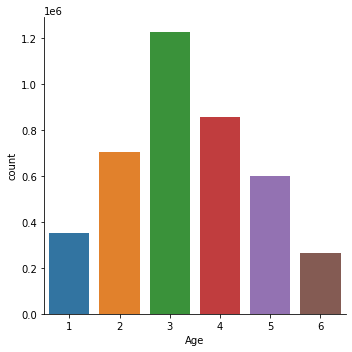

In [6]:
sns.catplot(x="Age", kind="count", data=data)

Inspecting the Target variable

0    0.952863
1    0.047136
Name: Click, dtype: float64

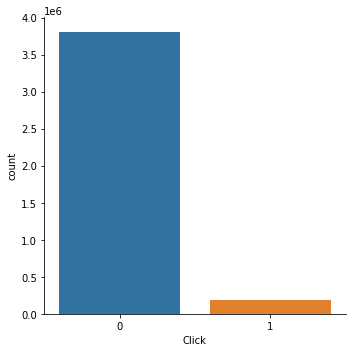

In [ ]:
# Target variable is Click
sns.catplot(x="Click", kind="count", data=data)
data['Click'].value_counts(normalize=True)

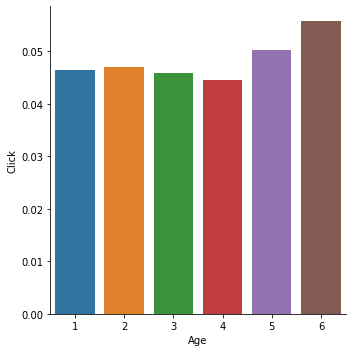

In [ ]:
sns.catplot(x="Age", y="Click", kind="bar", data=data, n_boot=1)

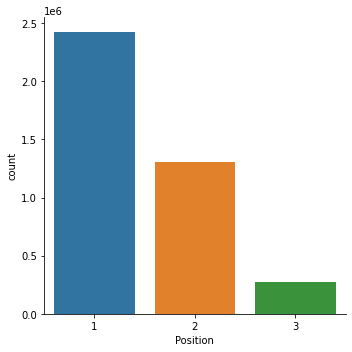

In [ ]:
sns.catplot(x="Position", kind="count", data=data)

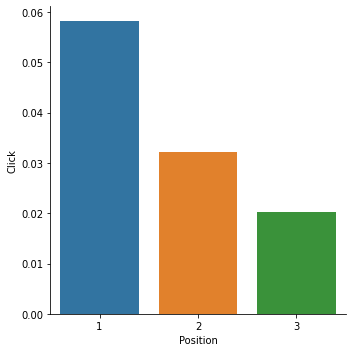

In [ ]:
sns.catplot(x="Position", y="Click", kind="bar", data=data, n_boot=1)

Dealing with the AdKeyword_tokens', 'AdTitle_tokens',
    'AdDescription_tokens', 'Query_tokens'

In [ ]:
#def split_labels(labels):
#  label_list = []
#  for i in labels:
#    label_list.append(''.join(str(i).split('|')))
#  return(label_list)

In [ ]:
# It might take time to load or crash
#data[['AdKeyword_tokens', 'AdTitle_tokens',
#       'AdDescription_tokens', 'Query_tokens']] =data[['AdKeyword_tokens', 'AdTitle_tokens',
#       'AdDescription_tokens', 'Query_tokens']].apply(lambda x: split_labels(x))

Data Correlation

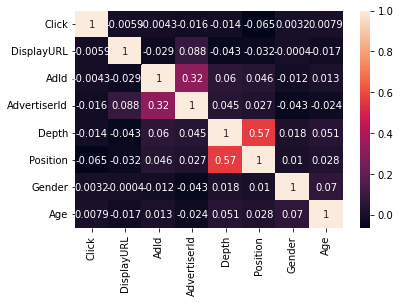

In [ ]:
from numpy.ma.core import size
a = data[['Click', 'DisplayURL', 'AdId', 'AdvertiserId', 'Depth',
       'Position', 'Gender', 'Age',]].corr()
sns.heatmap(a, annot=True)
plt.show()

Check the Shape of our data

In [ ]:

data.shape

(4000000, 13)

Get informaton about our dataset

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 13 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   ID                    int64 
 1   Click                 int64 
 2   DisplayURL            uint64
 3   AdId                  int64 
 4   AdvertiserId          int64 
 5   Depth                 int64 
 6   Position              int64 
 7   Gender                int64 
 8   Age                   int64 
 9   AdKeyword_tokens      object
 10  AdTitle_tokens        object
 11  AdDescription_tokens  object
 12  Query_tokens          object
dtypes: int64(8), object(4), uint64(1)
memory usage: 396.7+ MB


Check for Null values

In [ ]:
data.isnull().sum()

ID                      0
Click                   0
DisplayURL              0
AdId                    0
AdvertiserId            0
Depth                   0
Position                0
Gender                  0
Age                     0
AdKeyword_tokens        0
AdTitle_tokens          0
AdDescription_tokens    0
Query_tokens            0
dtype: int64

Check for unique values

In [ ]:
data.nunique()

ID                      4000000
Click                         2
DisplayURL                20694
AdId                     201256
AdvertiserId              13853
Depth                         3
Position                      3
Gender                        3
Age                           6
AdKeyword_tokens         253788
AdTitle_tokens           571682
AdDescription_tokens     460122
Query_tokens            1159879
dtype: int64

Check for overall stats of the Dataset

In [ ]:
data[['DisplayURL', 'AdId', 'AdvertiserId' ]].var()

DisplayURL      2.441419e+37
AdId            5.077532e+13
AdvertiserId    1.354512e+08
dtype: float64

In [7]:
data.describe()

,ID,Click,DisplayURL,AdId,AdvertiserId,Depth,Position,Gender,Age
count,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06
mean,2.999653e+06,4.713650e-02,9.722649e+18,1.612694e+07,2.278294e+04,1.911080e+00,1.460670e+00,1.425443e+00,3.360778e+00
std,1.732380e+06,2.119308e-01,4.941072e+18,7.125681e+06,1.163835e+04,6.943382e-01,6.194484e-01,5.226938e-01,1.343213e+00
min,0.000000e+00,0.000000e+00,4.824369e+14,1.000031e+06,7.800000e+01,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
25%,1.499202e+06,0.000000e+00,5.511132e+18,9.027615e+06,1.628300e+04,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00
50%,2.999491e+06,0.000000e+00,1.053897e+19,2.022297e+07,2.380800e+04,2.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00
75%,4.500149e+06,0.000000e+00,1.434039e+19,2.116392e+07,3.217400e+04,2.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00
max,5.999998e+06,1.000000e+00,1.844590e+19,2.223728e+07,3.916400e+04,3.000000e+00,3.000000e+00,2.000000e+00,6.000000e+00


We noticed that we have an Imbalance class and we have to find the best Metrics to it. 95% to 5% of data


### Exploration Of the Text columns


In [8]:
text_columns=['AdKeyword_tokens', 'AdTitle_tokens','AdDescription_tokens', 'Query_tokens']

In [9]:
avg_lengths = []
n_unique_words = []
n_words_covering_most_vocabulary = []
length_quantiles = []

for text_column in text_columns:
    print(text_column)
    text = data[text_column].str.split("|")

    QUANTILE= 0.95
    lengths = [len(tokens) for tokens in text.values]
    avg_len = np.mean(lengths)
    print(f"Average length of {text_column}: {avg_len:.2f}")
    avg_lengths.append(avg_len)
    len_quantile = np.quantile(lengths, QUANTILE)
    length_quantiles.append(len_quantile)
    print(f"{QUANTILE*100:.0f}% quantile of length: {len_quantile}")

    all_words = []
    for words in text.values:
        all_words.extend(words)
    # sorted counts of words (biggest first)
    all_words_count_values = [v for k, v in sorted(Counter(all_words).items(), key=lambda item: item[1], reverse=True)]  

    number_of_words = len(all_words_count_values)
    print(f"Number of unique words in {text_column}: {number_of_words}")
    n_unique_words.append(number_of_words)

AdKeyword_tokens
Average length of AdKeyword_tokens: 2.11
95% quantile of length: 4.0
Number of unique words in AdKeyword_tokens: 43265
AdTitle_tokens
Average length of AdTitle_tokens: 8.79
95% quantile of length: 14.0
Number of unique words in AdTitle_tokens: 53437
AdDescription_tokens
Average length of AdDescription_tokens: 21.33
95% quantile of length: 28.0
Number of unique words in AdDescription_tokens: 69671
Query_tokens
Average length of Query_tokens: 3.01
95% quantile of length: 6.0
Number of unique words in Query_tokens: 136536


### Dropping some Columns


In [10]:
data.columns

Index(['ID', 'Click', 'DisplayURL', 'AdId', 'AdvertiserId', 'Depth',
       'Position', 'Gender', 'Age', 'AdKeyword_tokens', 'AdTitle_tokens',
       'AdDescription_tokens', 'Query_tokens'],
      dtype='object')

In [ ]:
data1 = data.drop(['ID', 'AdKeyword_tokens', 'AdTitle_tokens',
       'AdDescription_tokens', 'Query_tokens'], axis=1)

In [ ]:
X = data1.drop('Click', axis=1)
y = data1['Click']

In [ ]:
X

,Depth,Position,Gender,Age
0,2,2,2,6
1,2,1,2,3
2,3,3,1,2
3,1,1,2,4
4,2,2,2,3
...,...,...,...,...
3999995,2,2,1,4
3999996,3,3,2,3
3999997,1,1,2,3
3999998,1,1,2,4


## Handling imbalance class with SMOTE


In [ ]:
from imblearn.over_sampling import SMOTE
X_res, y_res = SMOTE().fit_resample(X,y)

In [ ]:
y_res.value_counts()

1    3811454
0    3811454
Name: Click, dtype: int64

In [ ]:
?SMOTE()

Splitting Our Data to Train and test data


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res,
                                                    y_res,
                                                    test_size= 0.33,
                                                    random_state=42,
                                                    stratify=y_res
                                                    )

In [ ]:
print(y_test.shape)
print(X_train.shape)

(2515560,)
(5107348, 4)


### Feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

NameError: ignored

In [ ]:
X_test

array([[ 0.55240123, -1.86363062,  0.27003322, -0.58709743,  1.2308757 ,
         0.55074217],
       [-1.84223936, -0.17737919, -1.25698164, -0.58709743,  1.2308757 ,
         0.55074217],
       [ 0.70762201,  0.12226768,  0.27003322, -0.58709743, -0.71705576,
        -1.75738591],
       ...,
       [ 0.71221437,  1.11307832,  1.79704807, -0.58709743, -0.71705576,
        -0.98800989],
       [ 0.72107383, -0.37027205, -1.25698164, -0.58709743, -0.71705576,
         1.3201182 ],
       [-1.81150596,  0.12021471, -1.25698164, -0.58709743, -0.71705576,
         0.55074217]])

### Apply PCA

In [ ]:
#from sklearn.decomposition import PCA

In [ ]:
#pca = PCA(n_components=0.90)

In [ ]:
#X_train = pca.fit_transform(X_train)
#X_test = pca.transform(X_test)

In [ ]:
#sum(pca.explained_variance_ratio_)

1.0

### Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression 
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = lr.predict(X_test)

Metrics

In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, roc_auc_score, precision_score 

In [ ]:
accuracy_score(y_test, y_pred=y_pred)

0.6264221930994857

In [ ]:
precision_score(y_test, y_pred=y_pred)

0.5971762542684529

In [ ]:
recall_score(y_test, y_pred=y_pred)

0.7757952236706023

In [ ]:
f1_score(y_test, y_pred=y_pred)

0.6748668755251909

### Roc Auc

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresh = roc_curve(y_test, y_pred, pos_label=1)


In [ ]:
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [ ]:
auc_score = roc_auc_score(y_test, y_pred)

In [ ]:
np.unique(y_pred)

array([0, 1])

In [ ]:
auc_score

0.6264227470542951

### SVC

In [ ]:
from sklearn import svm

In [ ]:
svm = svm.SVC()

In [ ]:
svm.fit(X_train, y_train)

### KNeigbour Classiffer

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_pred2 = knn.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred=y_pred2)

0.6549008187162121

In [ ]:
precision_score(y_test, y_pred=y_pred2)

0.6991311573983366

In [ ]:
recall_score(y_test, y_pred=y_pred2)

0.5432589077125802

In [ ]:
f1_score(y_test, y_pred=y_pred2)

0.6114170413655781

### Decision Tree classifer

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [ ]:
y_pred3 = dt.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred=y_pred3)

0.6025146564763325

In [ ]:
precision_score(y_test, y_pred=y_pred3)

0.6624161227623189

In [ ]:
recall_score(y_test, y_pred=y_pred3)

0.41732640000839977

In [ ]:
f1_score(y_test, y_pred=y_pred3)

0.5120549204833401

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf =RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred4 = rf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred=y_pred4)

0.6314399619043122

In [ ]:
precision_score(y_test, y_pred=y_pred4)

0.7092441334984769

In [ ]:
recall_score(y_test, y_pred=y_pred4)

0.44492101574435244

In [ ]:
f1_score(y_test, y_pred=y_pred4)

0.5468153677900979

### gradient boost classifer

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbc= GradientBoostingClassifier()

In [ ]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier()

In [ ]:
y_pred5 = gbc.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred=y_pred5)

0.6473138210998162

In [ ]:
precision_score(y_test, y_pred=y_pred5)

0.6308992981731018

In [ ]:
recall_score(y_test, y_pred=y_pred5)

0.7091940928491556

In [ ]:
f1_score(y_test, y_pred=y_pred5)

0.6677595135451431

In [ ]:
df= pd.DataFrame({'Model':['LR','KNN','DTC', 'RFC', 'GBC'],
              'Accuracy Score': [accuracy_score(y_test, y_pred=y_pred),
                                 accuracy_score(y_test, y_pred=y_pred2),
                                 accuracy_score(y_test, y_pred=y_pred3),
                                 accuracy_score(y_test, y_pred=y_pred4),
                                 accuracy_score(y_test, y_pred=y_pred5)],
              'Precision Score': [precision_score(y_test, y_pred=y_pred),
                                  precision_score(y_test, y_pred=y_pred2),
                                  precision_score(y_test, y_pred=y_pred3),
                                  precision_score(y_test, y_pred=y_pred4),
                                  precision_score(y_test, y_pred=y_pred5)],
              'Recall Score': [recall_score(y_test, y_pred=y_pred),
                               recall_score(y_test, y_pred=y_pred2),
                               recall_score(y_test, y_pred=y_pred3),
                               recall_score(y_test, y_pred=y_pred4),
                               recall_score(y_test, y_pred=y_pred5)],
              'F1 Score': [f1_score(y_test, y_pred=y_pred),
                           f1_score(y_test, y_pred=y_pred2),
                           f1_score(y_test, y_pred=y_pred3),
                           f1_score(y_test, y_pred=y_pred4),
                           f1_score(y_test, y_pred=y_pred5)]})

NameError: ignored